## 오른쪽 발목

[[ 70.946106 107.203964]] <-- cnn예측 버전

64.0 112.0 <-- 오픈포즈 예측 버전

...

...

딱 오픈포즈만큼만 예측하고 있음 --> 오픈포즈가 인식 못했던 이미지 좌표 직접 찍어서 훈련 데이터셋에 넣어야 함

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os.path as osp
import os
import requests
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

#renet50 model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

100


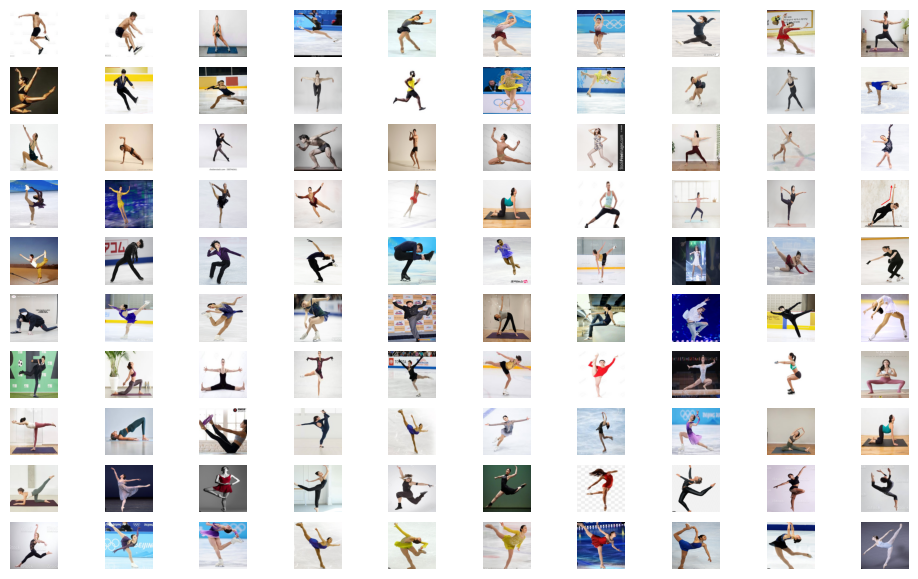

In [ ]:
image_folder = '/content/drive/MyDrive/2023ai/data set 100'
image_files = os.listdir(image_folder)
image_files.sort()

#image append
images = [] #list
for file_name in image_files:
    file_path = os.path.join(image_folder, file_name)
    image = cv2.imread(file_path)
    if image is not None:
        image = cv2.resize(image, (224, 224))
        images.append(image)

plt.figure(figsize=(12, 8))
columns = 10  #한 줄에 표시할 이미지 개수
rows = (len(images) // columns) + 1

#이미지를 순회하면서 표시
for i, image in enumerate(images):
    plt.subplot(rows, columns, i + 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  #BGR을 RGB로 변환
    plt.axis('off')

print(len(images))
plt.show()

104.0 56.0
80.0 72.0
72.0 72.0
152.0 56.0
96.0 24.0
72.0 64.0
72.0 48.0
96.0 24.0
72.0 104.0
112.0 160.0
64.0 112.0
80.0 96.0
120.0 104.0
120.0 208.0
72.0 88.0


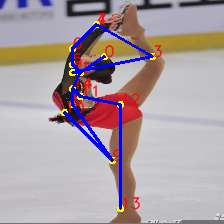

In [ ]:
BODY_PARTS = {"Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
              "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
              "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
              "Background": 15}

POSE_PAIRS = [["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
              ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
              ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
              ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"]]

# setting network
# setting network
protoFile='/content/drive/MyDrive/2023ai/pose_deploy_linevec_faster_4_stages.prototxt'
weightsFile='/content/drive/MyDrive/2023ai/pose_iter_160000.caffemodel'
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

image = cv2.imread('/content/drive/MyDrive/2023ai/test5.jpg')
image = cv2.resize(image, (224, 224))

imageHeight, imageWidth, imageColor = image.shape

#이미지 전처리
inpBlob = cv2.dnn.blobFromImage(image, 1.0 / 255, (imageWidth, imageHeight), (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)

output=net.forward()

H = output.shape[2]
W = output.shape[3]


# points 이미지에 입력
points = []
for i in range(0, 15):
    probMap = output[0, i, :, :]


    #(9.076588321477175e-05, 0.27673089504241943, (17, 11), (10, 12))
    if prob > 0.1:
        cv2.circle(image, (int(x), int(y)), 3, (0, 255, 255), thickness=-1,
                   lineType=cv2.FILLED)  # circle(그릴곳, 원의 중심, 반지름, 색)
        cv2.putText(image, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1,
                    lineType=cv2.LINE_AA)
        points.append((int(x), int(y)))
    else:
        points.append(None)

# 관절들 선으로 연결
for pair in POSE_PAIRS:
    partA = pair[0]  # Head
    partA = BODY_PARTS[partA]  # 0
    partB = pair[1]  # Neck
    partB = BODY_PARTS[partB]  # 1

    # print(partA," 와 ", partB, " 연결\n")
    if points[partA] and points[partB]:
        cv2.line(image, points[partA], points[partB], (255, 0, 0), 2)


cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# 배열 생성 = (이미지, 15(관절), 2(x, y))

points_array = np.zeros((len(images), 15, 2))

# 각 이미지에 대해 좌표 추출 및 저장
for i, image in enumerate(images):
    imageHeight, imageWidth, _ = image.shape
    #여기서 ,_는 color 라서 무시한다고 생각하면 됨

    inpBlob = cv2.dnn.blobFromImage(image, 1.0 / 255, (imageWidth, imageHeight), (0, 0, 0), swapRB=False, crop=False)

    net.setInput(inpBlob)
    output = net.forward()

    for j in range(0, 15):
        probMap = output[0, j, :, :]

        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

        # 원래 이미지에 맞게 점 위치 변경
        x = (imageWidth * point[0]) / W
        y = (imageHeight * point[1]) / H

        points_array[i, j, 0] = x
        points_array[i, j, 1] = y

print(points_array.shape)

(100, 15, 2)


In [ ]:
RAnkle_points = points_array[:, 10]
print(RAnkle_points.shape)
print(RAnkle_points)

(100, 2)
[[160. 128.]
 [136. 176.]
 [ 80. 176.]
 [176. 136.]
 [136. 176.]
 [144. 192.]
 [104. 184.]
 [168. 160.]
 [ 64. 184.]
 [ 64. 176.]
 [184. 120.]
 [104. 184.]
 [ 72. 176.]
 [ 96. 120.]
 [144. 192.]
 [168. 192.]
 [ 56. 112.]
 [ 80. 144.]
 [160. 192.]
 [ 40. 104.]
 [168. 200.]
 [160. 168.]
 [128. 160.]
 [104. 192.]
 [120. 176.]
 [192. 184.]
 [ 72. 184.]
 [152. 184.]
 [ 72. 160.]
 [136. 192.]
 [ 80.  48.]
 [ 88. 184.]
 [ 96. 192.]
 [120. 168.]
 [ 96. 152.]
 [ 56. 160.]
 [ 48. 200.]
 [ 88. 176.]
 [120. 200.]
 [ 48. 184.]
 [160. 104.]
 [ 32. 192.]
 [ 56. 176.]
 [152. 136.]
 [ 72. 160.]
 [152. 128.]
 [112. 184.]
 [ 96. 192.]
 [ 40.  48.]
 [144. 176.]
 [ 40. 160.]
 [176.  48.]
 [ 48. 104.]
 [104. 176.]
 [136. 216.]
 [ 80. 176.]
 [ 72. 136.]
 [ 96. 216.]
 [144. 192.]
 [ 56. 184.]
 [ 56.  96.]
 [ 56. 200.]
 [ 24. 176.]
 [ 40. 112.]
 [136. 192.]
 [104. 176.]
 [ 48. 192.]
 [ 64. 176.]
 [112. 176.]
 [ 48. 184.]
 [192.  80.]
 [176. 136.]
 [ 56.  80.]
 [120. 168.]
 [ 64.  24.]
 [ 64. 176.]
 [1

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input

In [ ]:
VGG_model = VGG16(weights='imagenet', include_top=False)
preprocessed_images = preprocess_input(np.array(images))
features = VGG_model.predict(preprocessed_images)

#저장
np.save('features.npy', features)

print(features.shape)
print(features[0])

4/4 [==============================] - 68s 15s/step
(100, 7, 7, 512)
[[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ... 11.131279    0.
    0.        ]
  ...
  [ 0.          0.          0.         ...  0.          0.
   14.290163  ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ... 25.622791    0.
    1.893483  ]
  ...
  [ 0.          0.          0.         ...  0.         10.410807
   16.493296  ]
  [ 0.          0.          0.         ...  0.          0.
    1.0007313 ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.   

In [ ]:
VGG_model = VGG16(weights='imagenet', include_top=False)

img_path = '/content/drive/MyDrive/2023ai/test5.jpg'


img_pil = Image.open(img_path).resize((224, 224))

img = np.array(img_pil)

x = np.expand_dims(img, axis=0)

x = preprocess_input(x)

features1 = VGG_model.predict(x)

print(features1.shape)

1/1 [==============================] - 1s 1s/step
(1, 7, 7, 512)


In [ ]:
from sklearn.model_selection import train_test_split

# train, test 비율 설정
train_ratio = 0.8  # train 데이터의 비율로 대체해야 합니다.
test_ratio = 0.2  # test 데이터의 비율로 대체해야 합니다.

# train, test로 데이터 분할
train_images, test_images, train_coords, test_coords = train_test_split(features, RAnkle_points, test_size=1-train_ratio)

# test 데이터를 다시 test, validation으로 분할
test_size = test_ratio / (1 - train_ratio)
test_images, validation_images, test_coords, validation_coords = train_test_split(test_images, test_coords, test_size=test_size)

print(train_images.shape)  # train 이미지 배열의 형상 출력
print(test_images.shape)  # test 이미지 배열의 형상 출력
print(validation_images.shape)  # validation 이미지 배열의 형상 출력
print(train_coords.shape)  # train 좌표값 배열의 형상 출력
print(test_coords.shape)  # test 좌표값 배열의 형상 출력
print(validation_coords.shape)  # validation 좌표값 배열의 형상 출력

(60, 7, 7, 512)
(20, 7, 7, 512)
(20, 7, 7, 512)
(60, 2)
(20, 2)
(20, 2)


In [ ]:
filter_size = 3
pool_size = 2

CNN_model = Sequential([
  keras.Input(shape=(7, 7, 512)),

#1layer
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D(pool_size=pool_size),

#2layer
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(filters = 50, kernel_size = filter_size, padding='same'),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D(pool_size=pool_size),


  Flatten(),
  Dense(50),
  Activation('relu'),

  Dense(10),
  Activation('relu'),

  Dense(2),

])

CNN_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 7, 7, 50)          230450    
                                                                 
 batch_normalization_8 (Batc  (None, 7, 7, 50)         200       
 hNormalization)                                                 
                                                                 
 activation_12 (Activation)  (None, 7, 7, 50)          0         
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 50)          22550     
                                                                 
 batch_normalization_9 (Batc  (None, 7, 7, 50)         200       
 hNormalization)                                                 
                                                                 
 activation_13 (Activation)  (None, 7, 7, 50)         

In [ ]:
CNN_model.compile(
  'adam',
  loss='mse', #회귀, losee=mse
  metrics=['accuracy'],
)

history = CNN_model.fit(train_images, train_coords, validation_data=(validation_images, validation_coords), epochs=50, batch_size=16)

# 모델 평가
test_loss, test_mae = CNN_model.evaluate(test_images, test_coords)

Epoch 1/50
4/4 [==============================] - 2s 126ms/step - loss: 287.2105 - accuracy: 0.9667 - val_loss: 4690.1826 - val_accuracy: 0.9000
Epoch 2/50
4/4 [==============================] - 0s 63ms/step - loss: 772.5402 - accuracy: 0.9667 - val_loss: 5009.7231 - val_accuracy: 0.9500
Epoch 3/50
4/4 [==============================] - 0s 49ms/step - loss: 694.8004 - accuracy: 0.9333 - val_loss: 5213.3784 - val_accuracy: 0.9000
Epoch 4/50
4/4 [==============================] - 0s 52ms/step - loss: 384.9326 - accuracy: 0.9500 - val_loss: 5321.2437 - val_accuracy: 0.9000
Epoch 5/50
4/4 [==============================] - 0s 50ms/step - loss: 452.4348 - accuracy: 0.8833 - val_loss: 4614.0825 - val_accuracy: 0.9000
Epoch 6/50
4/4 [==============================] - 0s 56ms/step - loss: 272.0577 - accuracy: 0.9667 - val_loss: 4477.9692 - val_accuracy: 0.9000
Epoch 7/50
4/4 [==============================] - 0s 50ms/step - loss: 372.5247 - accuracy: 0.9833 - val_loss: 4701.0420 - val_accuracy

In [ ]:
# 학습된 모델로 예측 수행
predictions = CNN_model.predict(features1)
print(predictions)

1/1 [==============================] - 0s 139ms/step
[[ 70.946106 107.203964]]


(-0.5, 223.5, 223.5, -0.5)

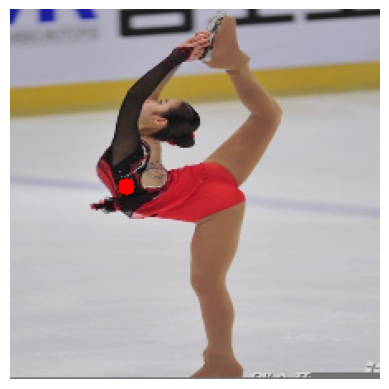

In [ ]:
import cv2
from google.colab import files
from matplotlib import pyplot as plt
image = cv2.imread('/content/drive/MyDrive/2023ai/test5.jpg')
image = cv2.resize(image, (224, 224))

# 좌표 설정
x = 70  # x 좌표
y = 107  # y 좌표

# 좌표에 점 찍기
cv2.circle(image, (x, y), radius=5, color=(0, 0, 255), thickness=-1)

# 이미지 출력
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

In [ ]:
[[ 70.946106 107.203964]]